# Example Queries: Customer Purchase Behavior

Demonstrates how the `customers` and `orders` marts can be queried to answer common business questions. Each query maps directly to columns and metrics defined in `_customers.yml` and `_orders.yml`.

**Questions covered:**

1. **Where should we focus marketing spend** — acquisition vs re-engagement?
2. **How often do customers return** to purchase additional eSIMs?
3. **How long does it take** for customers to come back and buy again?

In [46]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", message="BigQuery Storage module not found")

client = bigquery.Client(project="airalo-486008")

def run(sql):
    df = client.query(sql).to_dataframe()
    for col in df.select_dtypes(include=["object"]).columns:
        try:
            df[col] = pd.to_numeric(df[col])
        except (ValueError, TypeError):
            pass
    return df

plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11,
})

BLUE, ORANGE, GREEN, GREY = "#4A90D9", "#E8833A", "#5CB85C", "#AAAAAA"

Python(13744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


---
## 1. Where to Focus Marketing Spend

### 1a. Revenue split: new vs returning customers

Queries `is_first_purchase` and `order_amount_usd` from the **orders** mart.
Uses metrics: `new_customer_revenue_usd`, `repeat_customer_revenue_usd`, `new_customer_rate`.

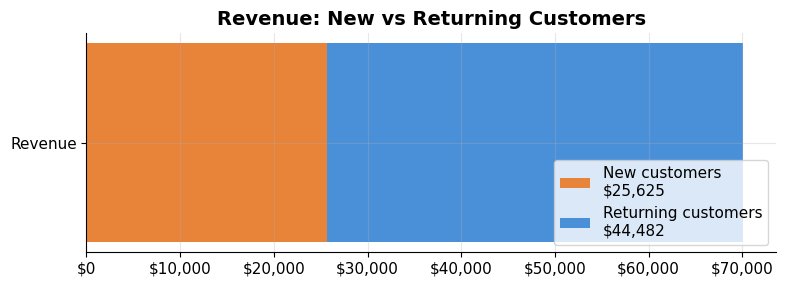

New customer rate: 37.5% of successful orders are first purchases
Returning customers drive 63.4% of total revenue


In [47]:
revenue_split = run("""
SELECT
    COUNT(DISTINCT CASE WHEN is_first_purchase THEN order_id END) AS first_purchases,
    COUNT(DISTINCT CASE WHEN NOT is_first_purchase
        AND customer_purchase_number IS NOT NULL THEN order_id END) AS repeat_purchases,
    ROUND(SAFE_DIVIDE(
        COUNT(DISTINCT CASE WHEN is_first_purchase THEN order_id END),
        COUNT(DISTINCT CASE WHEN customer_purchase_number IS NOT NULL THEN order_id END)
    ) * 100, 1) AS new_customer_rate_pct,
    ROUND(SUM(CASE WHEN order_is_completed AND is_first_purchase
        THEN order_amount_usd ELSE 0 END), 2) AS new_customer_revenue_usd,
    ROUND(SUM(CASE WHEN order_is_completed AND NOT is_first_purchase
        THEN order_amount_usd ELSE 0 END), 2) AS repeat_customer_revenue_usd,
    ROUND(SAFE_DIVIDE(
        SUM(CASE WHEN order_is_completed AND NOT is_first_purchase
            THEN order_amount_usd ELSE 0 END),
        SUM(CASE WHEN order_is_completed THEN order_amount_usd ELSE 0 END)
    ) * 100, 1) AS repeat_revenue_share_pct
FROM `airalo-486008.marts.orders`
""")

r = revenue_split.iloc[0]

fig, ax = plt.subplots(figsize=(8, 3))
vals = [r["new_customer_revenue_usd"], r["repeat_customer_revenue_usd"]]
labels = [f"New customers\n${vals[0]:,.0f}", f"Returning customers\n${vals[1]:,.0f}"]
ax.barh(["Revenue"], [vals[0]], color=ORANGE, label=labels[0])
ax.barh(["Revenue"], [vals[1]], left=[vals[0]], color=BLUE, label=labels[1])
ax.set_title("Revenue: New vs Returning Customers", fontsize=14, fontweight="bold")
ax.legend(loc="lower right")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"${x:,.0f}"))
plt.tight_layout()
plt.show()

print(f"New customer rate: {r['new_customer_rate_pct']}% of successful orders are first purchases")
print(f"Returning customers drive {r['repeat_revenue_share_pct']}% of total revenue")

### 1b. Channel breakdown

Queries `user_signup_acquisition_channel` and `is_first_purchase` from the **orders** mart.
Shows which channels produce the most repeat revenue — useful for evaluating re-engagement headroom per channel.

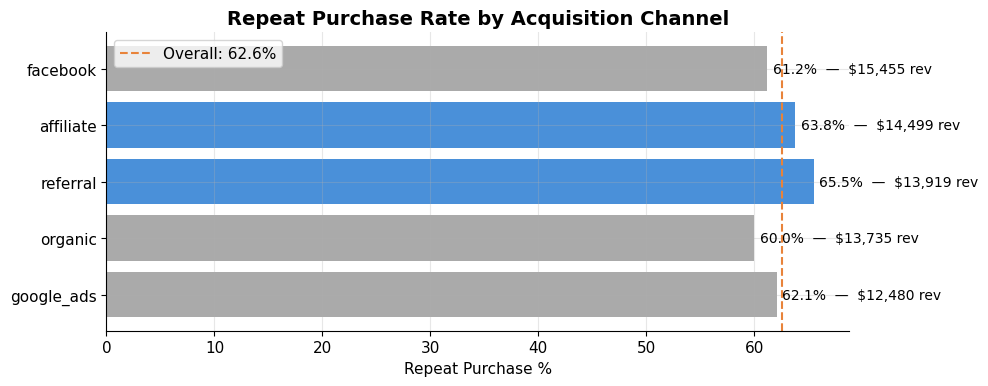

In [48]:
channels = run("""
SELECT
    user_signup_acquisition_channel AS channel,
    COUNT(DISTINCT user_id) AS customers,
    COUNT(DISTINCT CASE WHEN is_first_purchase THEN order_id END) AS first_purchases,
    COUNT(DISTINCT CASE WHEN NOT is_first_purchase
        AND customer_purchase_number IS NOT NULL THEN order_id END) AS repeat_purchases,
    ROUND(SAFE_DIVIDE(
        COUNT(DISTINCT CASE WHEN NOT is_first_purchase
            AND customer_purchase_number IS NOT NULL THEN order_id END),
        COUNT(DISTINCT CASE WHEN customer_purchase_number IS NOT NULL THEN order_id END)
    ) * 100, 1) AS repeat_purchase_pct,
    ROUND(SUM(CASE WHEN order_is_completed THEN order_amount_usd ELSE 0 END), 2)
        AS total_revenue_usd
FROM `airalo-486008.marts.orders`
GROUP BY 1
HAVING channel IS NOT NULL
ORDER BY total_revenue_usd DESC
""")

fig, ax = plt.subplots(figsize=(10, 4))
overall = channels["repeat_purchases"].sum() / (
    channels["first_purchases"].sum() + channels["repeat_purchases"].sum()) * 100
colors = [BLUE if v >= overall else GREY for v in channels["repeat_purchase_pct"]]
ax.barh(channels["channel"], channels["repeat_purchase_pct"], color=colors)
ax.axvline(overall, color=ORANGE, linestyle="--", linewidth=1.5,
           label=f"Overall: {overall:.1f}%")
ax.set_xlabel("Repeat Purchase %")
ax.set_title("Repeat Purchase Rate by Acquisition Channel", fontsize=14, fontweight="bold")
ax.legend()
ax.invert_yaxis()
for i, row in channels.iterrows():
    ax.text(row["repeat_purchase_pct"] + 0.5, i,
            f"{row['repeat_purchase_pct']}%  —  ${row['total_revenue_usd']:,.0f} rev",
            va="center", fontsize=10)
plt.tight_layout()
plt.show()

**Example insight:** 63% of revenue comes from returning customers. Referral and affiliate channels produce the highest repeat rates (~64-66%) while generating comparable total revenue to paid channels. Re-engagement and referral programs likely offer stronger ROI than pure acquisition spend. Organic has the lowest repeat rate — the biggest re-engagement opportunity.

---
## 2. How Often Do Customers Return?

Queries `total_purchases` and `is_repeat_purchaser` from the **customers** mart.
Uses metrics: `repeat_purchaser_rate`, `avg_purchases_per_customer`.

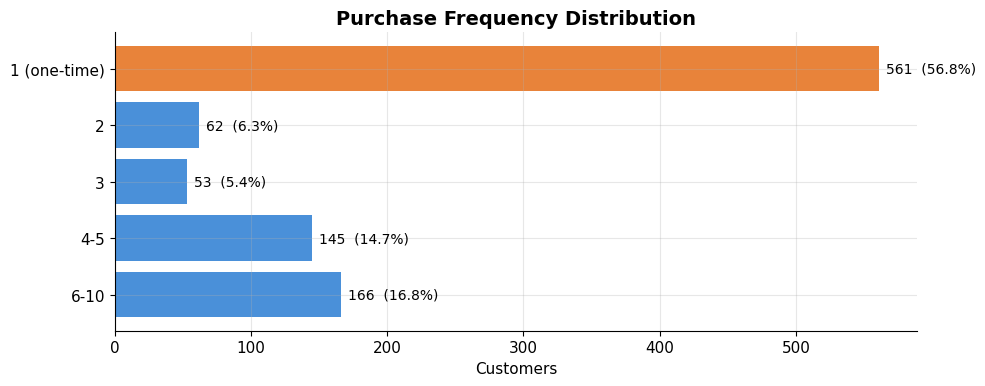

Repeat purchaser rate: 43.2% of buyers purchase more than once
Power users (6+ purchases): 166 customers


In [49]:
frequency = run("""
SELECT
    CASE
        WHEN total_purchases = 1 THEN '1 (one-time)'
        WHEN total_purchases = 2 THEN '2'
        WHEN total_purchases = 3 THEN '3'
        WHEN total_purchases BETWEEN 4 AND 5 THEN '4-5'
        WHEN total_purchases BETWEEN 6 AND 10 THEN '6-10'
        ELSE '11+'
    END AS purchase_bucket,
    COUNT(*) AS customers,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 1) AS pct_of_total,
    MIN(total_purchases) AS sort_key
FROM `airalo-486008.marts.customers`
WHERE total_purchases >= 1
GROUP BY 1
ORDER BY sort_key
""")

fig, ax = plt.subplots(figsize=(10, 4))
colors = [ORANGE if "one-time" in b else BLUE for b in frequency["purchase_bucket"]]
ax.barh(frequency["purchase_bucket"], frequency["customers"], color=colors)
ax.set_xlabel("Customers")
ax.set_title("Purchase Frequency Distribution", fontsize=14, fontweight="bold")
ax.invert_yaxis()
for i, row in frequency.iterrows():
    ax.text(row["customers"] + 5, i,
            f"{int(row['customers'])}  ({row['pct_of_total']}%)",
            va="center", fontsize=10)
plt.tight_layout()
plt.show()

repeat_pct = frequency.loc[frequency["sort_key"] > 1, "customers"].sum() / frequency["customers"].sum() * 100
print(f"Repeat purchaser rate: {repeat_pct:.1f}% of buyers purchase more than once")
print(f"Power users (6+ purchases): {frequency.loc[frequency['sort_key'] >= 6, 'customers'].sum()} customers")

**Example insight:** The distribution is bimodal — customers either buy once and leave (57%), or become frequent buyers. The 6-10 purchase power-user segment alone is ~17% of the base. Once a customer makes a second purchase, they're very likely to keep buying.

---
## 3. How Long to Come Back?

### 3a. Time to second purchase

Queries `days_to_second_purchase`, `has_repeat_within_90d`, `has_repeat_within_365d` from the **customers** mart.
Uses metrics: `avg_days_to_second_purchase`, `repeat_rate_90d`, `repeat_rate_365d`.

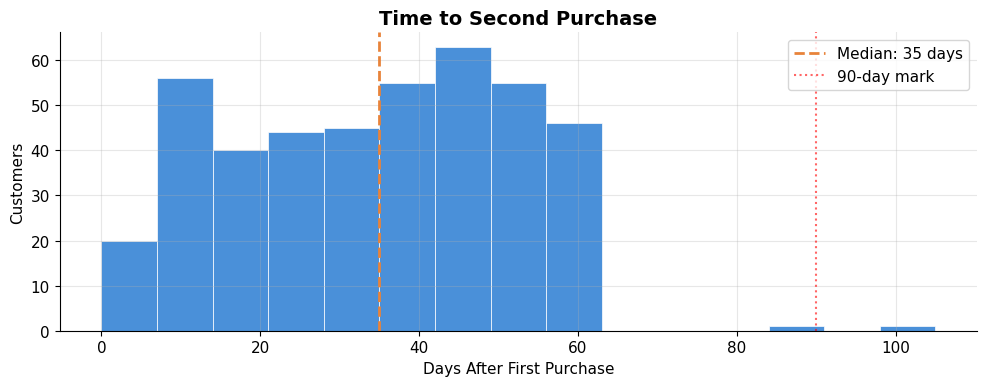

Median: 35 days  |  Avg: 33.9 days
99.8% come back within 90 days  |  100.0% within 365 days


In [50]:
time_to_2nd = run("""
SELECT days_to_second_purchase AS days
FROM `airalo-486008.marts.customers`
WHERE days_to_second_purchase IS NOT NULL
""")

summary = run("""
SELECT
    COUNT(*) AS repeat_customers,
    ROUND(AVG(days_to_second_purchase), 1) AS avg_days,
    ROUND(APPROX_QUANTILES(days_to_second_purchase, 100)[OFFSET(50)], 0) AS median_days,
    COUNTIF(has_repeat_within_90d) AS within_90d,
    ROUND(COUNTIF(has_repeat_within_90d) * 100.0 / COUNT(*), 1) AS pct_within_90d,
    ROUND(COUNTIF(has_repeat_within_365d) * 100.0 / COUNT(*), 1) AS pct_within_365d
FROM `airalo-486008.marts.customers`
WHERE is_repeat_purchaser
""")

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(time_to_2nd["days"], bins=range(0, int(time_to_2nd["days"].max()) + 7, 7),
        color=BLUE, edgecolor="white", linewidth=0.5)
median_d = time_to_2nd["days"].median()
ax.axvline(median_d, color=ORANGE, linestyle="--", linewidth=2,
           label=f"Median: {median_d:.0f} days")
ax.axvline(90, color="red", linestyle=":", linewidth=1.5, alpha=0.6, label="90-day mark")
ax.set_xlabel("Days After First Purchase")
ax.set_ylabel("Customers")
ax.set_title("Time to Second Purchase", fontsize=14, fontweight="bold")
ax.legend()
plt.tight_layout()
plt.show()

s = summary.iloc[0]
print(f"Median: {s['median_days']:.0f} days  |  Avg: {s['avg_days']} days")
print(f"{s['pct_within_90d']}% come back within 90 days  |  {s['pct_within_365d']}% within 365 days")

### 3b. Does the gap shrink with repeat purchases?

Queries `customer_purchase_number` and `days_since_previous_purchase` from the **orders** mart.
Uses metric: `avg_days_between_purchases`.

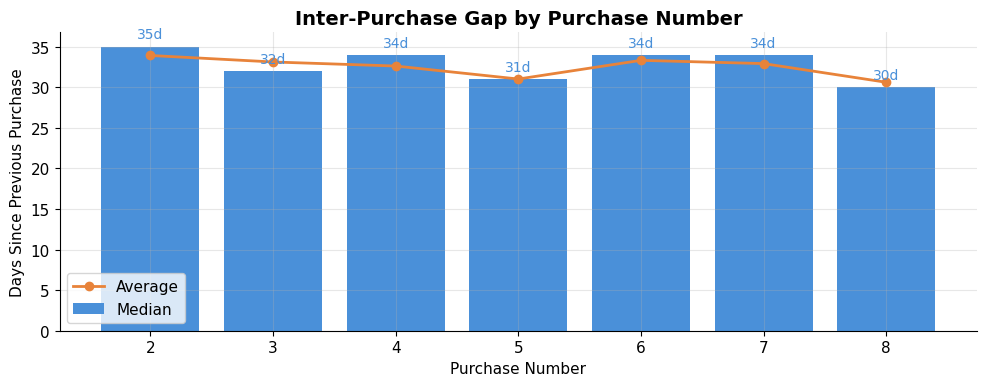

In [51]:
gap = run("""
SELECT
    customer_purchase_number AS purchase_num,
    COUNT(*) AS orders,
    ROUND(AVG(days_since_previous_purchase), 1) AS avg_days,
    ROUND(APPROX_QUANTILES(days_since_previous_purchase, 100)[OFFSET(50)], 0) AS median_days
FROM `airalo-486008.marts.orders`
WHERE customer_purchase_number BETWEEN 2 AND 8
    AND days_since_previous_purchase IS NOT NULL
GROUP BY 1
ORDER BY 1
""")

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(gap["purchase_num"].astype(str), gap["median_days"], color=BLUE, label="Median")
ax.plot(gap["purchase_num"].astype(str), gap["avg_days"], color=ORANGE,
        marker="o", linewidth=2, label="Average")
ax.set_xlabel("Purchase Number")
ax.set_ylabel("Days Since Previous Purchase")
ax.set_title("Inter-Purchase Gap by Purchase Number", fontsize=14, fontweight="bold")
ax.legend()
for i, row in gap.iterrows():
    ax.text(i, row["median_days"] + 1, f"{row['median_days']:.0f}d",
            ha="center", fontsize=10, color=BLUE)
plt.tight_layout()
plt.show()

**Example insight:** The repurchase cycle is remarkably consistent at ~31-35 days regardless of purchase number. This roughly monthly cadence likely reflects travel frequency. A re-engagement nudge at day 30-35 post-purchase would hit the natural repurchase window. Customers who haven't returned by day 90 are almost certainly churned.

---

## Columns and Metrics Reference

All queries above use columns and metrics defined in the mart YAML configs:

| Mart | Key columns queried | Metrics enabled for BI layer |
|---|---|---|
| `customers` | `is_repeat_purchaser`, `total_purchases`, `days_to_second_purchase`, `has_repeat_within_90d` | `repeat_purchaser_rate`, `avg_days_to_second_purchase`, `repeat_rate_90d` |
| `orders` | `is_first_purchase`, `customer_purchase_number`, `days_since_previous_purchase`, `order_amount_usd` | `new_customer_rate`, `new_customer_revenue_usd`, `repeat_customer_revenue_usd`, `avg_days_between_purchases` |